In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc 
import tqdm

% matplotlib inline

In [2]:
# Obtain all labels
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])
df = pd.read_csv('data/train_date.csv.zip', index_col=0)
df = df.join(response)

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
n_parts, n_columns = df.shape
n_columns -= 1
print(n_parts, n_columns)

1183747 1156


In [4]:
# stations and features in each station
stations = list(set([f.split('_')[1] for f in df.columns.tolist() if f!='Response']))

station_features = {s: [f for f in df.columns.tolist() if s in f] for s in stations }

In [5]:
# Calculate samples in each feature, if there is any station that every or almost every part flows by?
columns = df.columns.tolist()
feature_samples = {}
for col in tqdm.tqdm_notebook(columns):
    feature_samples[col] = len(df.loc[df[col].notna(), col])

feature_samples = pd.Series(feature_samples)
feature_samples.sort_values(ascending=False, inplace=True)
feature_samples.drop('Response', inplace=True)

In [6]:
s = {}
p = {}
for i, n in enumerate(feature_samples.unique()):
    s[i] = (n, feature_samples.loc[feature_samples==n].index.tolist())
    p[i] = (n, list(set([k.split('_')[1] for k in s[i][1]])))

### The number of segments in production
Productions with 3 segments or more tends to have different error distributions.

In [7]:
def segments(part_in, threshold=0.05):
    '''Calculate number of segments in a part.'''
    part_in.dropna(inplace=True)
    part_in.drop('Response', inplace=True)
    return sum(part_in.diff().fillna(0)>threshold) + 1

# df['segment'] = df.apply(segments, axis=1)

In [ ]:
threshold = 0.05
N = 100
segment = []
for i in tqdm.tqdm_notebook(range(n_parts//N+1)):
    tmp = df.iloc[i*N:min((i+1)*N, n_parts)].copy()
    segment.append(tmp.apply(segments, axis=1))
    
# segment = pd.DataFrame.from_dict(segment, orient='index')
# df.join(segment)

# segment = [segment[k] for k in segment.keys()]

segment = pd.concat(segment)

segment.name = 'segment'

df = df.join(segment)

In [ ]:
# Since it takes so long to calculate segment, let me save it.
segment = df['segment']
segment.name = 'segment'
segment.to_csv('train_segment.csv')

Parts with 2 segments have slightly lower error rate (0.005 vs 0.0058 on average), 3 and 4 segments are slightly higher. 5-segments parts are significantly higher than average (0.013 vs 0.0058 on average).

In [52]:
df.head()

,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,L0_S0_D19,...,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263,Response
Id,,,,,,,,,,,,,,,,,,,,,
4,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
11,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [12]:
a = df.groupby('segment').Response.agg(['mean', 'sum', 'count'])
a['confidence'] = 1.96 * np.sqrt(a['mean'] * (1 - a['mean']) / a['count'])
a['mean_plus'] = a['mean'] + a['confidence']
a['mean_minus'] = a['mean'] - a['confidence']
a

,mean,sum,count,confidence,mean_plus,mean_minus
segment,,,,,,
1,0.008777,29,3304,0.003181,0.011958,0.005597
2,0.004755,3424,720021,0.000159,0.004914,0.004597
3,0.007156,2518,351889,0.000278,0.007434,0.006877
4,0.007604,749,98495,0.000543,0.008147,0.007062
5,0.015485,142,9170,0.002527,0.018012,0.012958
6,0.017060,13,762,0.009195,0.026255,0.007866
7,0.031579,3,95,0.035166,0.066745,-0.003587
8,0.100000,1,10,0.185942,0.285942,-0.085942
9,0.000000,0,1,0.000000,0.000000,0.000000


In [14]:
b = df.groupby(['Response', 'segment']).Response.agg(['mean', 'sum', 'count'])
b.reset_index(level=1, inplace=True)

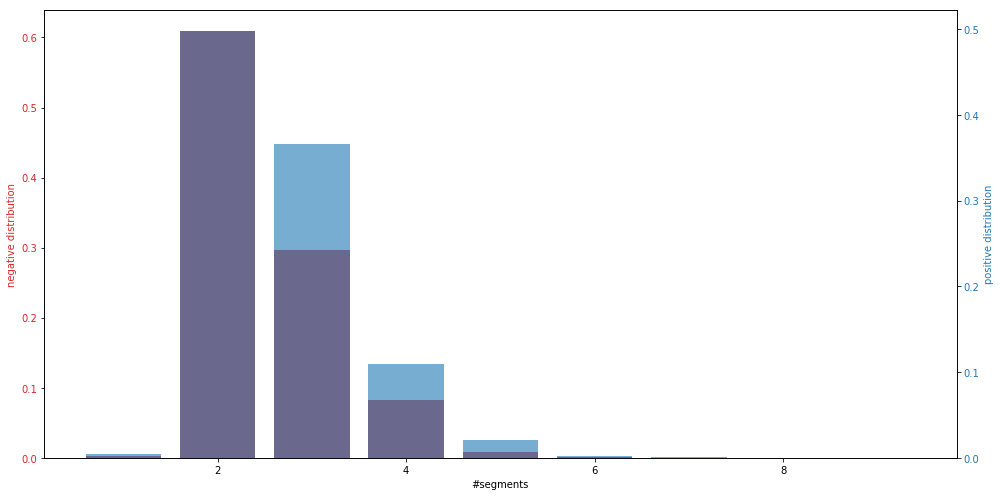

In [15]:
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('#segments')
ax1.set_ylabel('negative distribution', color=color)
#ax1.set_xlim([-0.5, Nxlim+0.5])
#xticks = ['{:.1f}'.format(tmp) for tmp in ax1.get_xticks() * tbin + 0.5 * tbin]
#ax1.set_xticklabels(xticks)
ax1.bar(b.loc[0, 'segment'], b.loc[0, 'count']/b.loc[0, 'count'].sum(), alpha=0.8, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('positive distribution', color=color)  # we already handled the x-label with ax1
ax2.bar(b.loc[1, 'segment'], b.loc[1, 'count']/b.loc[1, 'count'].sum(), alpha=0.6, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Does the segments corresponds to different lines? Actually no.

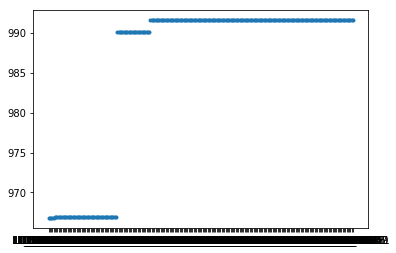

In [37]:
idx = df.loc[df.segment==4].index[0]

plt.plot(df.loc[idx].dropna().iloc[:-2], '.')

Some part can have 8 segments according to my calculation, 4 segments visually, and 3 production lines.

In [38]:
set([f.split('_')[0] for f in df.loc[idx].iloc[:-2].dropna().index.tolist()])

{'L1', 'L2', 'L3'}

### Start and end time on lines

In [195]:
line_features = {k: [c for c in columns if c.split('_')[0]==k] for k in ['L0', 'L1', 'L2', 'L3']}

In [197]:
def line_times(row_input):
    x = row_input.copy()
    x.dropna(inplace=True)
    x.drop(['Response', 'segment'], inplace=True)
    x_cols = x.index
    l = [[f for f in x.index if f.split('_')[0]=='L'+str(i)] for i in range(4)]
    for u, i in enumerate(l):
        if not i:
            x['L'+str(u)+'_start'] = np.nan
            x['L'+str(u)+'_end'] = np.nan
        else:
            x['L'+str(u)+'_start'] = x.loc[i].min() 
            x['L'+str(u)+'_end'] = x.loc[i].max()
    x.drop(x_cols, inplace=True)
    return x

In [ ]:
N =200
time_lines = []
for i in tqdm.tqdm_notebook(range(n_parts//N+1)):
    tmp = df.iloc[i*N:min((i+1)*N, n_parts)].copy()
    time_lines.append(tmp.apply(line_times, axis=1))
    
time_lines = pd.concat(time_lines)
time_lines.to_csv('train_time_lines.csv')
#df = df.join(time_lines)

In [160]:
df.head()

,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,L0_S0_D19,...,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263,Response,segment
Id,,,,,,,,,,,,,,,,,,,,,
4,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
7,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
9,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
11,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2


### Order of productions on each station or feature

Randomly pick one column `L3_S50_D4252`

In [ ]:
x = df.loc[df['L3_S50_D4252'].notna(), ['L3_S50_D4252', 'Response']].copy()
x.reset_index(inplace=True)
x.reset_index(inplace=True)

In [ ]:
x.sort_values('L3_S50_D4252', ascending=True, inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(x['L3_S50_D4252'], x['Response'])

Errors are not uniformly distributed in time. Calculate the distance to the nearest error on two sides.

In [ ]:
x.sort_values(['L3_S50_D4252', 'Id'], ascending=True, inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(x['L3_S50_D4252'].values)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
#   xs = randrange(n, 23, 32)
#   ys = randrange(n, 0, 100)
#   zs = randrange(n, zlow, zhigh)
#   ax.scatter(xs, ys, zs, c=c, marker=m)

ax.scatter(x.loc[x.Response==0, 'index'], x.loc[x.Response==0, 'Id'], x.loc[x.Response==0, 'L3_S50_D4252'], c='b')
ax.scatter(x.loc[x.Response==1, 'index'], x.loc[x.Response==1, 'Id'], x.loc[x.Response==1, 'L3_S50_D4252'], c='r')

ax.set_xlabel('index')
ax.set_ylabel('Id')
ax.set_zlabel('time')

plt.show()

Each part is determined by index after sorting, ID, and time. Plotting these 3d tuples in 3d space, find that ID and index are equivalent. Since ID is more general in testing set, index will not be used.

In [ ]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# import numpy as np

# trace1 = go.Scatter3d(
#     x=x.loc[x.Response==0, 'index'], 
#     y=x.loc[x.Response==0, 'Id'], 
#     z=x.loc[x.Response==0, 'L3_S50_D4252'],
#     mode='markers',
#     marker=dict(
#         size=0.5,
#         line=dict(
#             color='rgba(217, 217, 217, 0.14)',
#             width=0.5
#         ),
#         opacity=0.8
#     )
# )

# trace2 = go.Scatter3d(
#     x=x.loc[x.Response==1, 'index'], 
#     y=x.loc[x.Response==1, 'Id'], 
#     z=x.loc[x.Response==1, 'L3_S50_D4252'],
#     mode='markers',
#     marker=dict(
#         color='rgb(127, 127, 127)',
#         size=2,
#         symbol='circle',
#         line=dict(
#             color='rgb(255, 0, 0)',
#             width=1
#         ),
#         opacity=0.9
#     )
# )
# data = [trace1, trace2]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='simple-3d-scatter')


In [ ]:
plt.scatter(x=x.loc[x.Response==0, 'index']+ x.loc[x.Response==0, 'Id'], y=x.loc[x.Response==0, 'L3_S50_D4252'])
plt.scatter(x=x.loc[x.Response==1, 'index']+ x.loc[x.Response==1, 'Id'], y=x.loc[x.Response==1, 'L3_S50_D4252'])

In [ ]:
plt.scatter(x=x.loc[x.Response==0, 'Id'], y=x.loc[x.Response==0, 'L3_S50_D4252'])
plt.scatter(x=x.loc[x.Response==1, 'Id'], y=x.loc[x.Response==1, 'L3_S50_D4252'])